In [2]:
!pip install fuzzywuzzy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
movies_filename = '/content/drive/My Drive/SWMdata/movies.csv'
ratings_filename = '/content/drive/My Drive/SWMdata/ratings.csv'
df_movies = pd.read_csv(
    movies_filename,
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [6]:
df_movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int32 
 1   title    27278 non-null  object
dtypes: int32(1), object(1)
memory usage: 319.8+ KB


In [7]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [8]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [9]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 138493 unique users and 26744 unique movies in this data set


In [10]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [11]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,3683856529
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [12]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,3683856529,22.027226
0.5,239125,12.384742
1.0,680732,13.430924
1.5,279252,12.539870
2.0,1430997,14.173882
2.5,883398,13.691531
3.0,4291193,15.272075
3.5,2200156,14.604039
4.0,5561926,15.531455
4.5,1534824,14.243926


Text(0, 0.5, 'number of ratings')

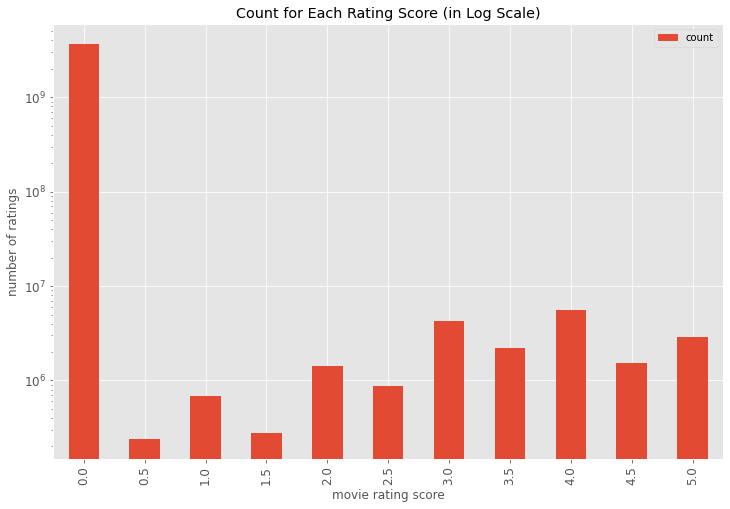

In [13]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [14]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [15]:
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161


Text(0, 0.5, 'number of ratings')

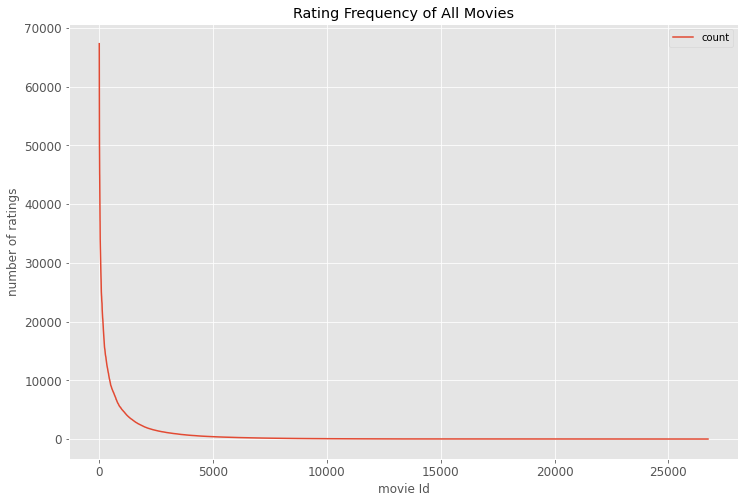

In [16]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

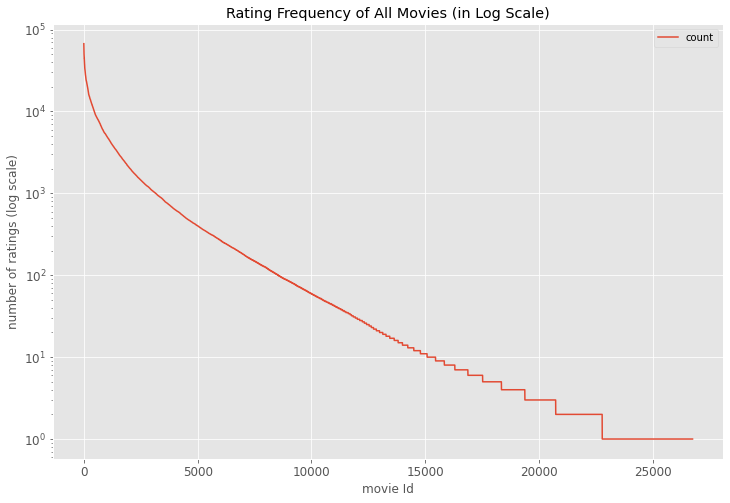

In [17]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [19]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    67310.00
0.95     3612.95
0.90     1305.70
0.85      632.55
0.80      346.00
0.75      205.00
0.70      123.00
0.65       74.00
Name: count, dtype: float64

In [22]:
# filter data
popularity_thres = 50
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (20000263, 3)
shape of ratings data after dropping unpopular movies:  (19847947, 3)


In [23]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,174
2,61
3,187
4,28
5,66


Text(0, 0.5, 'number of ratings')

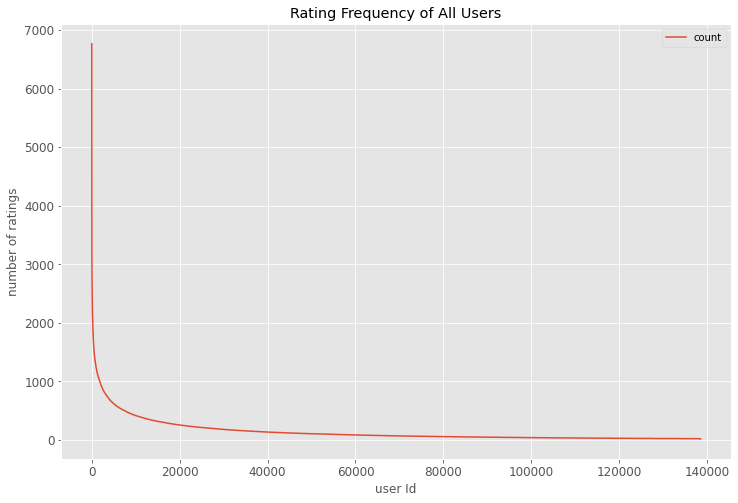

In [24]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [25]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    6769.0
0.95     518.0
0.90     333.0
0.85     246.0
0.80     192.0
0.75     154.0
0.70     127.0
0.65     107.0
0.60      92.0
0.55      78.0
Name: count, dtype: float64

In [0]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (20000263, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (18181935, 3)


In [0]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,1,2,3,5,7,8,11,13,14,16,18,19,21,22,23,24,25,26,27,29,31,32,33,34,35,38,40,41,42,43,46,47,48,50,51,53,54,56,58,60,...,138424,138426,138427,138429,138431,138432,138435,138436,138437,138439,138441,138443,138444,138446,138449,138450,138452,138454,138455,138456,138457,138458,138459,138461,138464,138467,138470,138471,138472,138473,138474,138475,138477,138483,138484,138486,138487,138490,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,0.0,5.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,0.0,...,5.0,0.0,0.0,0.0,5.0,4.0,0.0,3.5,4.0,4.0,5.0,3.5,0.0,5.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,4.0,0.0,4.5,3.0,4.5,5.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,3.5
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
movie_to_idx
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [0]:
print(movie_to_idx)

{'Toy Story (1995)': 0, 'Jumanji (1995)': 1, 'Grumpier Old Men (1995)': 2, 'Waiting to Exhale (1995)': 3, 'Father of the Bride Part II (1995)': 4, 'Heat (1995)': 5, 'Sabrina (1995)': 6, 'Tom and Huck (1995)': 7, 'Sudden Death (1995)': 8, 'GoldenEye (1995)': 9, 'American President, The (1995)': 10, 'Dracula: Dead and Loving It (1995)': 11, 'Balto (1995)': 12, 'Nixon (1995)': 13, 'Cutthroat Island (1995)': 14, 'Casino (1995)': 15, 'Sense and Sensibility (1995)': 16, 'Four Rooms (1995)': 17, 'Ace Ventura: When Nature Calls (1995)': 18, 'Money Train (1995)': 19, 'Get Shorty (1995)': 20, 'Copycat (1995)': 21, 'Assassins (1995)': 22, 'Powder (1995)': 23, 'Leaving Las Vegas (1995)': 24, 'Othello (1995)': 25, 'Now and Then (1995)': 26, 'Persuasion (1995)': 27, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28, 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29, 'Dangerous Minds (1995)': 30, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 31, 'Wings of Courage (1995)': 

In [0]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [0]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [0]:
my_favorite = 'Batman Begins'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Batman Begins
Found possible matches in our database: ['Batman Begins (2005)']

Recommendation system start to make inference
......

Recommendations for Batman Begins:
1: Pirates of the Caribbean: The Curse of the Black Pearl (2003), with distance of 0.40687549114227295
2: Casino Royale (2006), with distance of 0.40617120265960693
3: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance of 0.4026415944099426
4: Spider-Man 2 (2004), with distance of 0.4008358120918274
5: V for Vendetta (2006), with distance of 0.39375239610671997
6: Lord of the Rings: The Two Towers, The (2002), with distance of 0.38871610164642334
7: Incredibles, The (2004), with distance of 0.38687920570373535
8: Sin City (2005), with distance of 0.38273656368255615
9: Dark Knight, The (2008), with distance of 0.37289780378341675
10: Lord of the Rings: The Return of the King, The (2003), with distance of 0.3648024797439575
